In [1]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from calendar import monthrange
import os, json
from rasterstats import zonal_stats
import rasterio
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# load datasets
project_files = "/home/sergei/Downloads/vkr/code_base/project_data/"
fires_path = project_files + "fires_with_factors/"
years = list(range(2015, 2025))
print(
    "Paths:", project_files, fires_path,
    "Years:", years, sep="\n"
)

fires_ds_l = []
for year_ in years:
    fires_geojson_path = fires_path + f"factor_dataset_{str(year_)}.geojson"
    ds = gpd.read_file(fires_geojson_path)
    fires_ds_l.append(ds)
print(f"Imported {len(fires_ds_l)} datasets")

Paths:
/home/sergei/Downloads/vkr/code_base/project_data/
/home/sergei/Downloads/vkr/code_base/project_data/fires_with_factors/
Years:
[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Imported 10 datasets


In [3]:
# print the first dataset as an example
print(
    "Shape:", fires_ds_l[0].shape, "Columns:", fires_ds_l[0].dtypes, 
    "(Non)fire ratio:", fires_ds_l[0].is_fire.value_counts(), sep="\n"
)
print("Nan values:\n", fires_ds_l[0].isnull().sum())
pd.options.display.max_columns = None   # show all columns
fires_ds_l[0].head(5)

Shape:
(2757, 27)
Columns:
year                        int32
lat                       float64
lon                       float64
event_date         datetime64[ms]
is_fire                     int32
grid_lat                  float64
grid_lon                  float64
T                         float64
RH                        float64
WIND_DIR_STD              float64
WIND_SPEED                float64
APCP                      float64
elevation                 float64
slope                     float64
aspect                    float64
vegetation_type           float64
road_type                  object
road_id                     int32
road_dist                 float64
river_id                    int32
river_dist                float64
locality_type              object
locality_id                object
locality_dist             float64
techno_obj_id               int32
techno_obj_dist           float64
geometry                 geometry
dtype: object
(Non)fire ratio:
is_fire
0    1660
1    1

,year,lat,lon,event_date,is_fire,grid_lat,grid_lon,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,vegetation_type,road_type,road_id,road_dist,river_id,river_dist,locality_type,locality_id,locality_dist,techno_obj_id,techno_obj_dist,geometry
0,2015,60.0217,115.8679,2015-07-16,1,60.0,116.0,18.295625,65.603125,105.826192,2.156250,0.928125,756.285714,3.867853,228.993504,21.0,прочая,152,193759.177102,228,21785.981741,село сельский,05.���,114105.573893,106,493120.164862,"POLYGON ((12897309.459 8403569.034, 12897309.1..."
1,2015,59.7178,115.0410,2015-08-06,1,59.5,115.0,16.455938,61.846875,108.147393,1.509375,0.296875,794.625000,4.589434,279.286755,1.0,прочая,152,231036.127592,219,23197.616858,село сельский,05.���,219916.158194,610,384503.700491,"POLYGON ((12805346.404 8336204.874, 12805346.1..."
2,2015,59.5761,113.9840,2015-09-25,1,59.5,114.0,0.158437,79.846875,118.414201,2.253125,0.200000,511.181818,7.200536,310.846270,11.0,прочая,152,281283.822800,220,1721.018231,село сельский,17.���,182717.515536,144,295530.312784,"POLYGON ((12687257.185 8304795.856, 12687256.7..."
3,2015,59.4877,113.6689,2015-09-24,1,59.5,113.5,0.922187,78.928125,128.074350,2.343750,0.215625,512.181818,2.837777,216.993585,15.0,прочая,152,312789.373320,220,25686.184906,село сельский,17.���,142391.828552,144,263925.972009,"POLYGON ((12653525.898 8287187.746, 12653525.7..."
4,2015,59.3922,114.0660,2015-07-12,1,59.5,114.0,19.102581,63.635484,90.308355,2.041935,0.361290,899.625000,5.854614,227.141216,1.0,прочая,152,316608.671509,220,15611.137720,поселок сельский,05.���,158680.082953,145,264187.329925,"POLYGON ((12696710.022 8264660.54, 12696709.73..."


In [4]:
# concatenate datasets
fires_dataset = pd.concat(fires_ds_l, ignore_index=True)
print("Shape:", fires_dataset.shape, 
      "Columns:", fires_dataset.dtypes,
      "(Non)fires ratio:", fires_dataset.is_fire.value_counts(), sep="\n"
)
print("Nan values:", fires_dataset.isnull().sum(), sep="\n")

Shape:
(19864, 27)
Columns:
year                        int32
lat                       float64
lon                       float64
event_date         datetime64[ms]
is_fire                     int32
grid_lat                  float64
grid_lon                  float64
T                         float64
RH                        float64
WIND_DIR_STD              float64
WIND_SPEED                float64
APCP                      float64
elevation                 float64
slope                     float64
aspect                    float64
vegetation_type           float64
road_type                  object
road_id                     int32
road_dist                 float64
river_id                    int32
river_dist                float64
locality_type              object
locality_id                object
locality_dist             float64
techno_obj_id               int32
techno_obj_dist           float64
geometry                 geometry
dtype: object
(Non)fires ratio:
is_fire
0    11537
1  

In [5]:
# what are some basic steps to do before training
# clean data:
# deal with the missing values (done), outliers (a z-score normalization) (not done)
# and inconsistencies (wrong naming or metrics, for ex, convert currencies to one unit or 
# word capitalization) (done)

# transform data:
# normalize data () or standardize it (use z-score ((a - mean) / std_dev) - read about the difference
# scale data (put it in a certain range)
# convert categorical data to numerical

# feature creation (create the new informative feature from the multiple existing)

# carefull with chronological order so that the past data doesn't leak to the test dataset

# reduce data
# dimensionality reduction (get rid of the data without losing information) - for ex, PCA

# balance the data (for ex, if fires are much more than non-fires)

# split data (the data should be balanced in both datasets)

# repeat the same operations for the test data (if you did it after splitting)
#

# Methods:
# z-score normalizatioin centers data distribution around 0, min-max scaling bounds values
# within specific range



# https://www.knime.com/blog/four-basic-steps-in-data-preparation
# https://www.knime.com/blog/seven-techniques-for-data-dimensionality-reduction
# https://www.pecan.ai/blog/data-preparation-for-machine-learning/
# https://lakefs.io/blog/machine-learning-data-preparation/
# https://www.techtarget.com/searchbusinessanalytics/feature/Data-preparation-in-machine-learning-6-key-steps
# https://www.datastax.com/guides/how-to-prepare-data-for-ai
# https://www.phdata.io/blog/how-to-prepare-data-for-use-in-machine-learning-models/
# https://www.researchgate.net/post/Do_we_need_to_standardize_variables_with_different_scales_before_doing_correlation_analysis
# 



In [6]:
# tried to do smth with locity type, decide to drop it for now
pd.get_dummies(fires_dataset.locality_type)
fires_dataset.locality_type.value_counts()
fires_dataset.locality_type.unique()
a = list(map(lambda x: x.replace(" ", "").lower(), fires_dataset.locality_type.unique()))
a
len(a), len(set(a))
set(a)
s = list(set(a))
p = len(s)
seen = []
for i in range(p):
    print(i)
    for j in range(p):
        if s[i] in s[j]:
            print(s[i], s[j])
    seen.append(s[i])

0
селосельский селосельский
1
участоксельский участоксельский
2
городгородской городгородской
3
деревня деревня
деревня деревнясельский
деревня деревнясльский
4
поселок поселок
поселок рабочийпоселокгородской
поселок поселокж.д.станциисельский
поселок поселоксельский
5
деревнясельский деревнясельский
6
город городгородской
город город
город рабочийпоселокгородской
7
блок-постсельский блок-постсельский
8
рабочийпоселокгородской рабочийпоселокгородской
9
хуторсельский хуторсельский
10
заимкасельский заимкасельский
11
поселокж.д.станциисельский поселокж.д.станциисельский
12
поселоксельский поселоксельский
13
деревнясльский деревнясльский
14
район район


In [7]:
fires_dataset.vegetation_type.value_counts().sort_index()

vegetation_type
1.0     1628
6.0      661
8.0      159
10.0     330
11.0    2449
12.0    4840
13.0     174
15.0    1461
17.0     956
18.0    6548
21.0     549
25.0     109
Name: count, dtype: int64

In [8]:
fires_dataset.columns

Index(['year', 'lat', 'lon', 'event_date', 'is_fire', 'grid_lat', 'grid_lon',
       'T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation', 'slope',
       'aspect', 'vegetation_type', 'road_type', 'road_id', 'road_dist',
       'river_id', 'river_dist', 'locality_type', 'locality_id',
       'locality_dist', 'techno_obj_id', 'techno_obj_dist', 'geometry'],
      dtype='object')

In [9]:
exclude_cols = [
    "event_date", "lat", "lon", "grid_lat", "grid_lon", "road_type", "road_id", 
    "river_id", "locality_id", "locality_type", "techno_obj_id", "geometry"
]
train_dataset = fires_dataset.loc[:, ~(fires_dataset.columns.isin(exclude_cols))].round(decimals=6)
train_dataset["vegetation_type"] = train_dataset["vegetation_type"].astype(int)
print(train_dataset.dtypes)
train_dataset.head(5)

year                 int32
is_fire              int32
T                  float64
RH                 float64
WIND_DIR_STD       float64
WIND_SPEED         float64
APCP               float64
elevation          float64
slope              float64
aspect             float64
vegetation_type      int64
road_dist          float64
river_dist         float64
locality_dist      float64
techno_obj_dist    float64
dtype: object


,year,is_fire,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,vegetation_type,road_dist,river_dist,locality_dist,techno_obj_dist
0,2015,1,18.295625,65.603125,105.826192,2.156250,0.928125,756.285714,3.867853,228.993504,21,193759.177102,21785.981741,114105.573893,493120.164862
1,2015,1,16.455938,61.846875,108.147393,1.509375,0.296875,794.625000,4.589434,279.286755,1,231036.127592,23197.616858,219916.158194,384503.700491
2,2015,1,0.158437,79.846875,118.414201,2.253125,0.200000,511.181818,7.200536,310.846270,11,281283.822800,1721.018231,182717.515536,295530.312784
3,2015,1,0.922187,78.928125,128.074350,2.343750,0.215625,512.181818,2.837777,216.993585,15,312789.373320,25686.184906,142391.828552,263925.972009
4,2015,1,19.102581,63.635484,90.308355,2.041935,0.361290,899.625000,5.854614,227.141216,1,316608.671509,15611.137720,158680.082953,264187.329925


<Axes: >

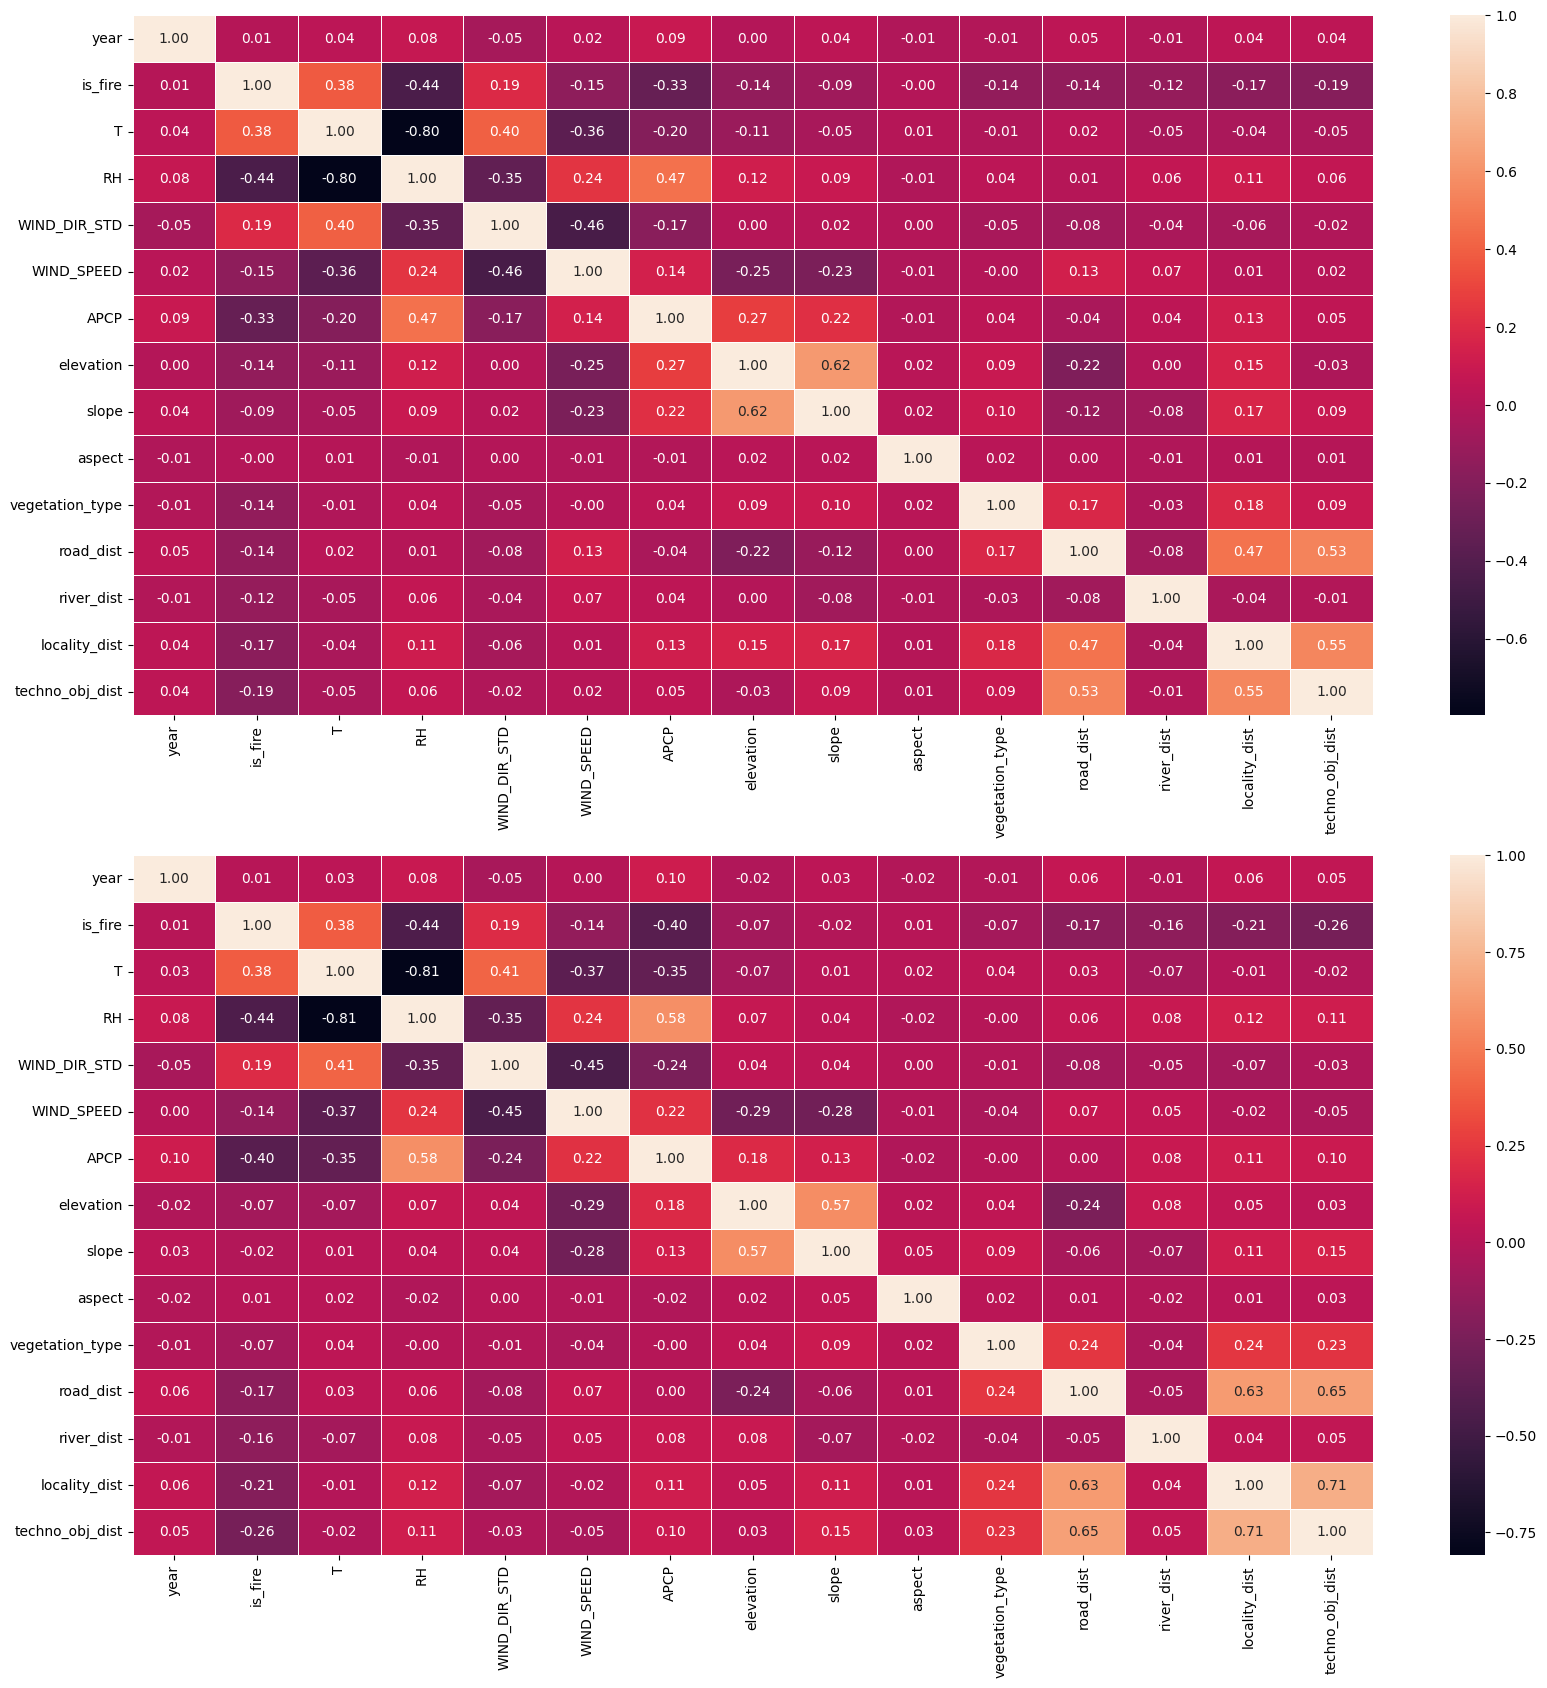

In [10]:
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 1)
pr = train_dataset.corr(method="pearson")
sp = train_dataset.corr(method="spearman")
# pr.loc[["WIND_DIR_STD", "WIND_SPEED"], :]
# sp.loc[["WIND_DIR_STD", "WIND_SPEED"], :]
sns.heatmap(pr, annot=True, linewidths=0.5, fmt=".2f", ax=ax[0])
sns.heatmap(sp, annot=True, linewidths=0.5, fmt=".2f", ax=ax[1])

In [12]:
# pearson correlation with pvalue
train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
pearson_corr_d = {}
moderate_pearson_corr_d = {}
strong_pearson_corr_d = {}
for i in range(train_ds.shape[1]):
    col = train_ds.iloc[:, i]
    print(f"Checking column {col.name}")
    pearson_corr_d[col.name] = {}
    moderate_pearson_corr_d[col.name] = {}
    strong_pearson_corr_d[col.name] = {}
    for j in range(train_ds.shape[1]):
        col_ = train_ds.iloc[:, j]
        r, p_value = st.pearsonr(col, col_)
        print(f"{col.name} {col_.name} Coeff: {r}, p_value: {p_value}")
        if p_value < 0.05:
            print("Correlation exists")
            pearson_corr_d[col.name][col_.name] = r
            if 0.3 <= abs(r) < 0.5:
                moderate_pearson_corr_d[col.name][col_.name] = r
            elif abs(r) >= 0.5:
                strong_pearson_corr_d[col.name][col_.name] = r
        else:
            print("Correlation doesn't exist")
    print("\n")
print(
    "All",
    json.dumps(pearson_corr_d, indent=4), 
    "Moderate:",
    json.dumps(moderate_pearson_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_pearson_corr_d, indent=4),
    sep="\n"
)

Checking column is_fire
is_fire is_fire Coeff: 1.0, p_value: 0.0
Correlation exists
is_fire T Coeff: 0.38045295432790316, p_value: 0.0
Correlation exists
is_fire RH Coeff: -0.4408897410897258, p_value: 0.0
Correlation exists
is_fire WIND_DIR_STD Coeff: 0.1881499250066112, p_value: 1.068261316358092e-157
Correlation exists
is_fire WIND_SPEED Coeff: -0.15116224681432716, p_value: 7.541858122657899e-102
Correlation exists
is_fire APCP Coeff: -0.32592519538151865, p_value: 0.0
Correlation exists
is_fire elevation Coeff: -0.13803263445676175, p_value: 4.402281341999958e-85
Correlation exists
is_fire slope Coeff: -0.0850360178037459, p_value: 3.3065676373960525e-33
Correlation exists
is_fire aspect Coeff: -0.0026473092484955497, p_value: 0.7090828347693242
Correlation doesn't exist
is_fire road_dist Coeff: -0.14245850531924836, p_value: 1.473606089251913e-90
Correlation exists
is_fire river_dist Coeff: -0.123962985185613, p_value: 7.361398439383255e-69
Correlation exists
is_fire locality_dis

In [14]:
# spearman correlation with pvalue
train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
spearman_corr_d = {}
moderate_spearman_corr_d = {}
strong_spearman_corr_d = {}
for i in range(train_ds.shape[1]):
    col = train_ds.iloc[:, i]
    print(f"Checking column {col.name}")
    spearman_corr_d[col.name] = {}
    moderate_spearman_corr_d[col.name] = {}
    strong_spearman_corr_d[col.name] = {}
    for j in range(train_ds.shape[1]):
        col_ = train_ds.iloc[:, j]
        r, p_value = st.spearmanr(col, col_)
        print(f"{col.name} {col_.name} Coeff: {r}, p_value: {p_value}")
        if p_value < 0.05:
            print("Correlation exists")
            spearman_corr_d[col.name][col_.name] = r
            if 0.3 <= abs(r) < 0.5:
                moderate_spearman_corr_d[col.name][col_.name] = r
            elif abs(r) >= 0.5:
                strong_spearman_corr_d[col.name][col_.name] = r
        else:
            print("Correlation doesn't exist")
    print("\n")
print(
    "All",
    json.dumps(spearman_corr_d, indent=4), 
    "Moderate:",
    json.dumps(moderate_spearman_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_spearman_corr_d, indent=4),
    sep="\n"
)

Checking column is_fire
is_fire is_fire Coeff: 1.0, p_value: 0.0
Correlation exists
is_fire T Coeff: 0.3804078336859371, p_value: 0.0
Correlation exists
is_fire RH Coeff: -0.43865416390358275, p_value: 0.0
Correlation exists
is_fire WIND_DIR_STD Coeff: 0.1893070446332479, p_value: 1.182220146851603e-159
Correlation exists
is_fire WIND_SPEED Coeff: -0.14399458379699034, p_value: 1.683551154586036e-92
Correlation exists
is_fire APCP Coeff: -0.3983147985716767, p_value: 0.0
Correlation exists
is_fire elevation Coeff: -0.07424229050320247, p_value: 1.0961544314838718e-25
Correlation exists
is_fire slope Coeff: -0.01730434289813599, p_value: 0.014732122978403855
Correlation exists
is_fire aspect Coeff: 0.010511195671463493, p_value: 0.13850201397618797
Correlation doesn't exist
is_fire road_dist Coeff: -0.1724427410704802, p_value: 2.0755092595197438e-132
Correlation exists
is_fire river_dist Coeff: -0.16003874530664852, p_value: 4.394046846171485e-114
Correlation exists
is_fire locality_di

(13, 13) (13, 13)


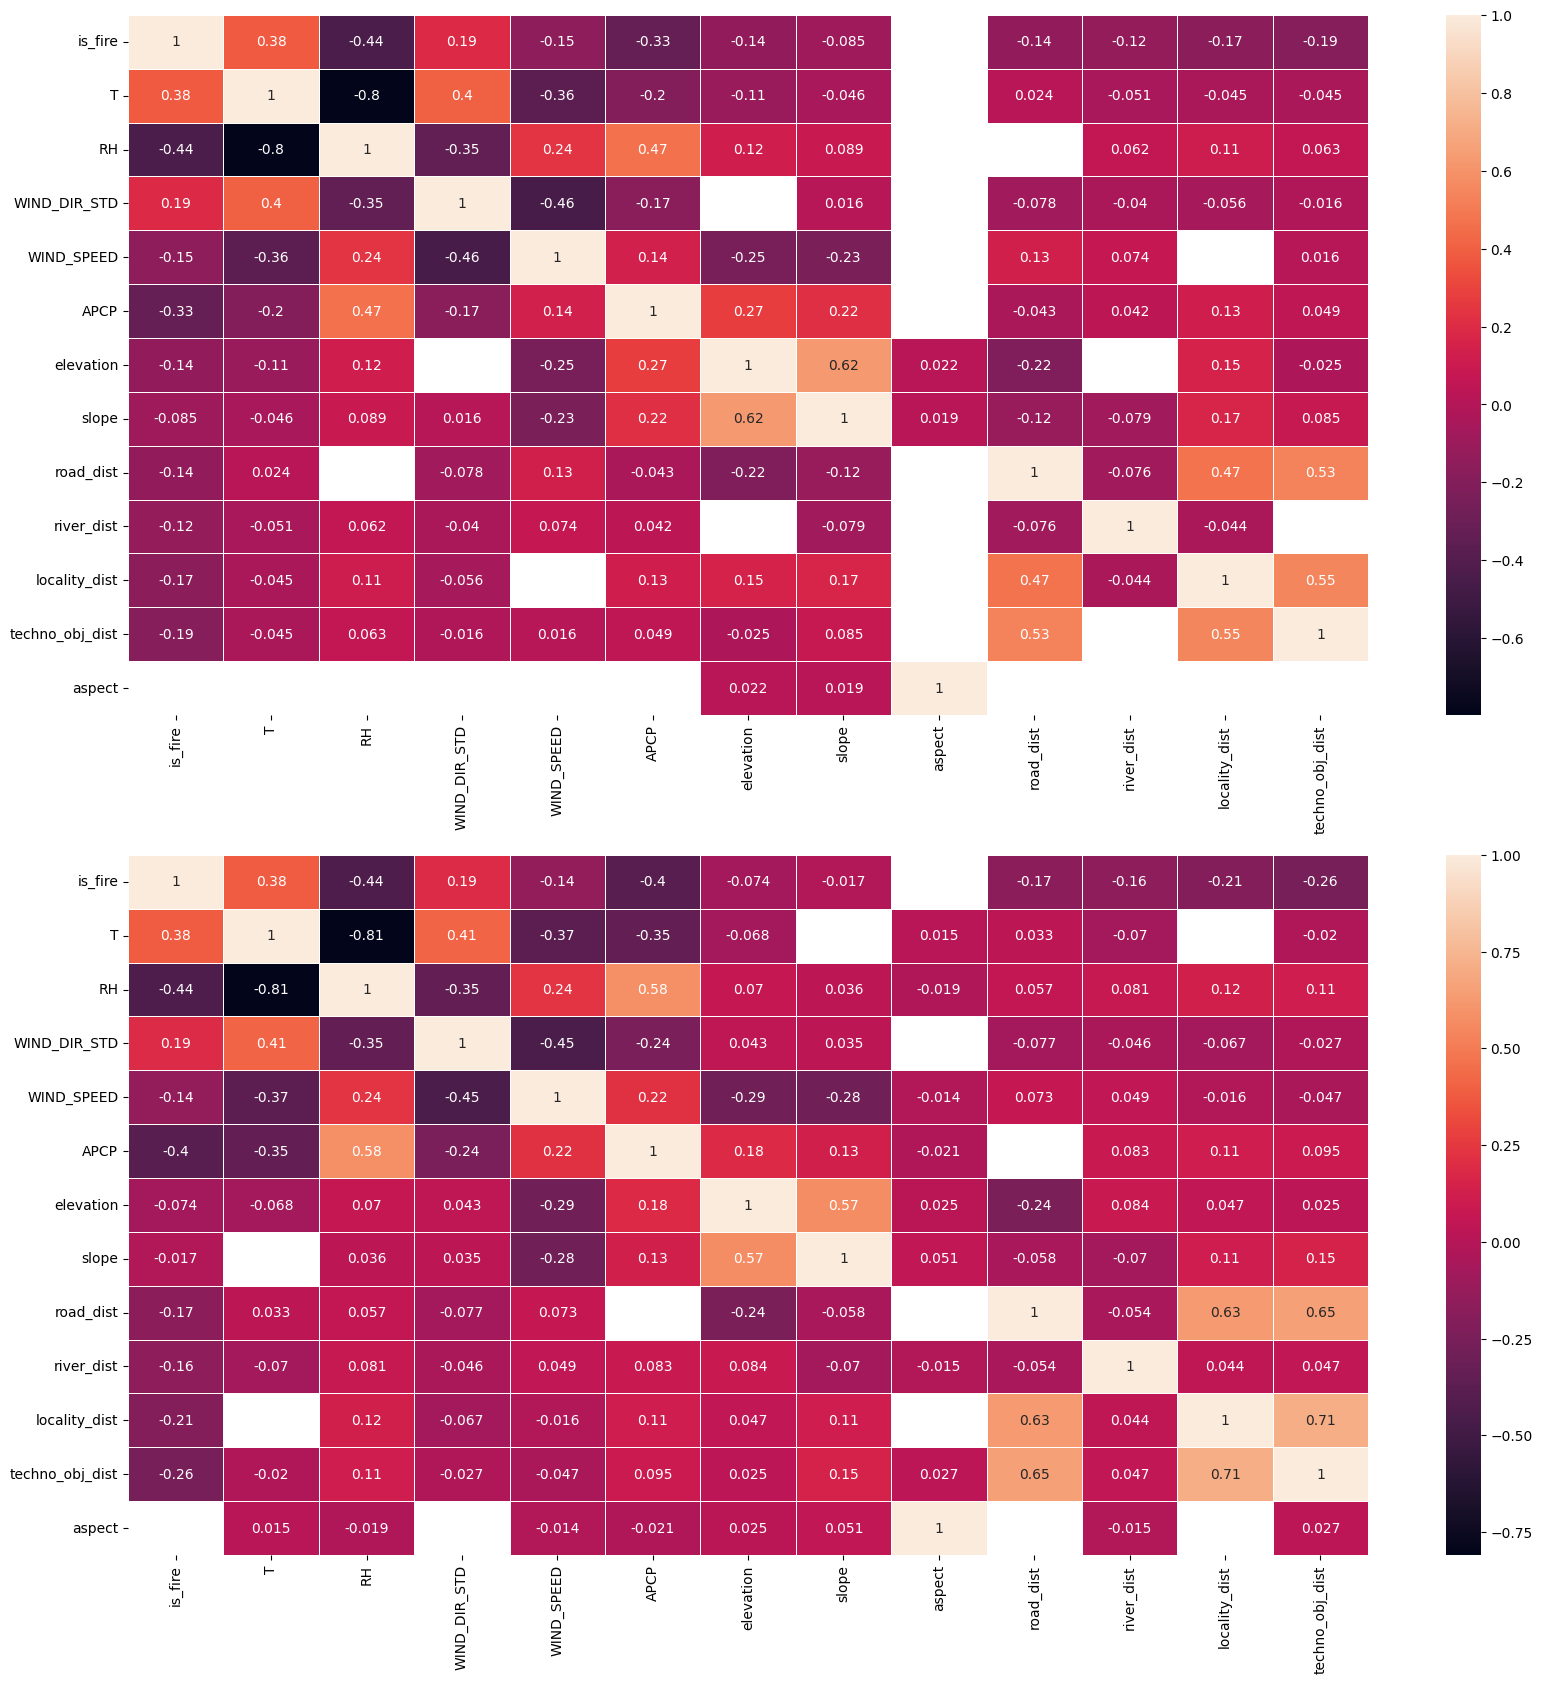

In [16]:
# correlations matrix
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 1)
pearson_m = pd.DataFrame(pearson_corr_d)
spearman_m = pd.DataFrame(spearman_corr_d)
print(pearson_m.shape, spearman_m.shape)
sns.heatmap(pearson_m, annot=True, ax=ax[0], linewidths=0.5)
sns.heatmap(spearman_m, annot=True, ax=ax[1], linewidths=0.5)
fig.savefig("out.png")

In [18]:
# features: is_fire, T, RH, wind_dir_std, wind_speed, apcp, elevation, slope, aspect
# road_dist, river_dist, locality_dist, techno_obj_dist
# highly correlated features
# pearson: T - RH, elevation - slope, road_dist - techno_obj_dist, locality_dist - techno_obj_dist
# spearman: T - RH, RH - apcp, elevation - slope, road_dist - locality_dist & techno_obj_dist, locality_dist - 
# techno_obj_dist
# VIF > 5: RH, wind_dir, wind_speed, elevation    
print(
    "Pearson",
    "Moderate:",
    json.dumps(moderate_pearson_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_pearson_corr_d, indent=4),
    "\nSpearman",
    "Moderate:",
    json.dumps(moderate_spearman_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_spearman_corr_d, indent=4),
    sep="\n"
)

Pearson
Moderate:
{
    "is_fire": {
        "T": 0.38045295432790316,
        "RH": -0.4408897410897258,
        "APCP": -0.32592519538151865
    },
    "T": {
        "is_fire": 0.38045295432790316,
        "WIND_DIR_STD": 0.3998152006295516,
        "WIND_SPEED": -0.3640178218093669
    },
    "RH": {
        "is_fire": -0.4408897410897258,
        "WIND_DIR_STD": -0.34563864391423404,
        "APCP": 0.4652780983556054
    },
    "WIND_DIR_STD": {
        "T": 0.3998152006295516,
        "RH": -0.34563864391423404,
        "WIND_SPEED": -0.45860712889369865
    },
    "WIND_SPEED": {
        "T": -0.3640178218093669,
        "WIND_DIR_STD": -0.45860712889369865
    },
    "APCP": {
        "is_fire": -0.32592519538151865,
        "RH": 0.4652780983556054
    },
    "elevation": {},
    "slope": {},
    "aspect": {},
    "road_dist": {
        "locality_dist": 0.4724894801913984
    },
    "river_dist": {},
    "locality_dist": {
        "road_dist": 0.4724894801913984
    },
    "t

In [19]:
# VIF
train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
VIF = pd.DataFrame()
VIF["feature"] = list(train_ds.columns)
VIF["VIF"] = [variance_inflation_factor(train_ds.values, i) for i in range(train_ds.shape[1])] 
VIF

,feature,VIF
0,is_fire,2.273466
1,T,3.943035
2,RH,31.897854
3,WIND_DIR_STD,13.921619
4,WIND_SPEED,16.386305
5,APCP,2.935741
6,elevation,9.031017
7,slope,3.363038
8,aspect,4.972382
9,road_dist,3.585982


In [158]:
# gr = sns.pairplot(train_dataset)
# gr.fig.savefig("out1.png")
train_ds.columns

Index(['is_fire', 'T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation',
       'slope', 'aspect', 'road_dist', 'river_dist', 'locality_dist',
       'techno_obj_dist'],
      dtype='object')

In [ ]:
{'SOILW40': 'Влажность почвы (в слое 10-40см), %',
 'SOILW200': 'Влажность почвы (в слое 100-200см), %',
 'TMIN': 'Минимальная температура, °С',
 'SNOD': 'Глубина снега, м',
 'TMPGR40': 'Температура почвы (в слое 10-40см), °С',
 'T': 'Температура, °С',
 'DATE': 'Дата',
 'WIND_SPEED': 'Скорость ветра, м/c',
 'TMPGR100': 'Температура почвы (в слое 40-100см), °С',
 'LAT': 'Широта, °',
 'TMPGR10': 'Температура почвы (в слое 0-10см), °С',
 'LON': 'Долгота, °',
 'TMAX': 'Максимальная температура, °С',
 'RH': 'Относительная влажность, %',
 'APCP': 'Количество осадков, кг/м2',
 'TIME': 'Время',
 'WIND_DIR': 'Направление ветра, °',
 'TMPGR200': 'Температура почвы (в слое 100-200см), °С',
 'SOILW10': 'Влажность почвы (в слое 0-10см), %',
 'SOILW100': 'Влажность почвы (в слое 40-100см), %'}

In [21]:
# ex = ["WIND_SPEED", "elevation", "RH"]
ex = ["RH"]
ds = train_ds.loc[:, ~train_ds.columns.isin(ex)]
VIF = pd.DataFrame()
VIF["feature"] = list(ds.columns)
VIF["VIF"] = [variance_inflation_factor(ds.values, i) for i in range(ds.shape[1])] 
VIF

,feature,VIF
0,is_fire,2.268439
1,T,2.730596
2,WIND_DIR_STD,10.125486
3,WIND_SPEED,9.761717
4,APCP,2.533732
5,elevation,8.622484
6,slope,3.358837
7,aspect,4.824549
8,road_dist,3.528248
9,river_dist,2.266341


In [ ]:
feature 	VIF
0 	is_fire 	2.273466
1 	T 	3.943035
2 	RH 	31.897854
3 	WIND_DIR_STD 	13.921619
4 	WIND_SPEED 	16.386305
5 	APCP 	2.935741
6 	elevation 	9.031017
7 	slope 	3.363038
8 	aspect 	4.972382
9 	road_dist 	3.585982
10 	river_dist 	2.297431
11 	locality_dist 	3.720248
12 	techno_obj_dist 	2.807375

In [82]:
# wind_speed, elevation

<Axes: >

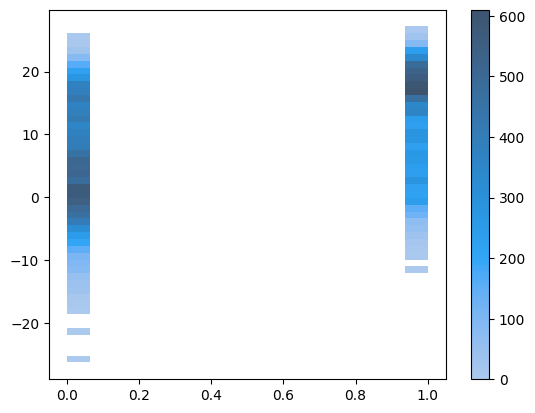

In [43]:
sns.histplot(x=train_ds["is_fire"].values, y=train_ds["T"].values, cbar=True)

In [48]:
# https://www.kaggle.com/code/aymenkhouja/introduction-to-feature-selection
# split target and features, count z-score on feature, then unite datasets to count correlations
a = (train_ds - train_ds.mean()) / train_ds.std()
a.describe()

,is_fire,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,road_dist,river_dist,locality_dist,techno_obj_dist
count,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04,1.986400e+04
mean,2.339383e-16,-9.300298e-17,4.063515e-16,-1.716978e-17,7.068226e-16,2.861630e-17,6.295586e-17,2.003141e-17,-2.214186e-16,-1.981679e-16,5.222475e-17,-1.430815e-17,1.860060e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.495460e-01,-3.906980e+00,-2.547781e+00,-2.964445e+00,-2.364860e+00,-1.014962e+00,-1.564647e+00,-9.789924e-01,-2.018860e+00,-1.041144e+00,-1.099441e+00,-1.104291e+00,-7.979376e-01
25%,-8.495460e-01,-8.050493e-01,-8.422456e-01,-6.920484e-01,-7.328630e-01,-7.035038e-01,-6.525064e-01,-6.327272e-01,-7.457689e-01,-8.046878e-01,-7.465670e-01,-8.088629e-01,-6.250704e-01
50%,-8.495460e-01,2.465881e-02,1.178205e-01,3.564450e-02,-1.132572e-01,-2.550034e-01,-2.904354e-01,-3.595824e-01,-2.560788e-02,-3.723785e-01,-2.332772e-01,-2.770943e-01,-3.664706e-01
75%,1.177040e+00,8.844116e-01,8.665305e-01,7.106617e-01,5.948636e-01,3.803721e-01,3.988921e-01,2.862168e-01,7.163276e-01,5.751819e-01,4.710703e-01,5.330761e-01,1.351470e-01
max,1.177040e+00,2.105052e+00,1.572427e+00,3.381427e+00,5.142327e+00,1.244628e+01,7.017133e+00,8.677587e+00,2.093658e+00,2.988948e+00,6.191088e+00,4.189124e+00,5.086013e+00
